   # Assembling dataframes for FORM 460 for primary election, 6/5/18, Silicon Valley Organization PAC   
   ## Here's a resource for GeoJSON files for all 50 states https://github.com/OpenDataDE/State-zip-code-GeoJSON
   -The transaction types can't be trusted because they have inconsistent documentations, sometimes REC_type is a Receipt RCPT,but it's actually an expense.
see lines 0,1, where Amount is negative, but last column calls it a receipt.   
   -if tran amount is <0 but listed as a RCPT, it's an expense.   
   -Transcation_ID Strings begin with    
   * INC for Income/donation,   
   * EXP in Tran_ID for expenses,   
   * EDT for expenses by third party on behalf of committee.   
   (Expense types are tracked in 'Expn_code' and codes can be referenced on any schedule E documents.)   
   * PAY for a debt or a loan. Debt types have NaN amounts in Amount and are tracked instead by   
   'Amt_Beg','Amt_This P','Amt_Paid','Amt_Close'. Loan Types have values in amount and additional   
   tracking in columns like debt type.  

-We had planned on looking mainly where money comes from, but I have a feeling we may need to see where money goes to, especially with these PACs, as it seems like that's how their donations to candidates are documented (though it could be that there's a duplicate of the information if we look at INC for the candidates, in which case it would show the PAC as the donator instead of the receipient).   
   -Long story short:   
   For donation tracking purposes, the most reliable way to isolate donations is by the Tran_ID prefix.   

   I initially imported all forms 460, including 460a, but found duplicates, so went back to investigate.  The amended report (460-A) is the first report plus any additions, so only 460a should be used. Scraper will need to somehow determine that if no 460-A exists for that date range, to instead use form 460. If this can't be done, then import all forms 460, and drop duplicates which can be identified by Tran_ID   
   -reports starting 7/1/17 and 7/1/18 don't have duplicates, so forms 460 rather than 460A were used   

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
!conda install -c conda-forge folium=0.5.0 --yes
import folium
import requests

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
#arranging the excel sheets as pandas dataframes
df = pd.read_excel(r'C:\Users\StephenP\Desktop\transactionExportGrid.xls')
df1 = pd.read_excel(r'C:\Users\StephenP\Desktop\transactionExportGrid (2).xls')
df2 = pd.read_excel(r'C:\Users\StephenP\Desktop\transactionExportGrid (4).xls')
df3 = pd.read_excel(r'C:\Users\StephenP\Desktop\transactionExportGrid (6).xls')
df4 = pd.read_excel(r'C:\Users\StephenP\Desktop\transactionExportGrid (8).xls')
df5 = pd.read_excel(r'C:\Users\StephenP\Desktop\transactionExportGrid (9).xls')
df6 = pd.read_excel(r'C:\Users\StephenP\Desktop\transactionExportGrid (11).xls')
print('done')

done


In [3]:
#check individual shape for consistency, and to compare w concatenated df in next step
print(df.shape,df1.shape,df2.shape,df3.shape,df4.shape,df5.shape,df6.shape)

(229, 88) (118, 88) (97, 88) (20, 88) (19, 88) (261, 88) (51, 88)


In [4]:
#generating 1 dataframe composed of all others and making sure it all adds up, yes
df = pd.concat([df,df1,df2,df3,df4,df5,df6])
df.shape

(795, 88)

In [5]:
#instead of removing trash columns, generating new df w only columns we want
#we want data from entity nam L thru Filer_nam L most (will rename next), as discussed last meeting 
#other columns may be needed later for transparency into those values
wholedf = df[['Entity_Nam L','Entity_City','Entity_ST','Entity_ZIP4','Amount','Tran_ID','Tran_Date','Filer_Nam L','Expn_Code','Entity_Emp','Entity_Cd','Amt_Beg','Amt_This P','Amt_Paid','Amt_Close','Entity_Nam F','Rec_Type']]

In [6]:
#renaming the columns
wholedf.rename(columns={'Entity_Nam L':'Name','Entity_City:':'City','Entity_ST':'State','Entity_ZIP4':'ZIP','Tran_ID':'Transaction ID','Tran_Date':'Date','Filer_Nam L':'Recipient','Expn_Code':'Expense Type','Entity_Emp':'Donor Employer','Entity_Cd':'Organization_Type','Amt_Beg':'Initial Debt','Amt_This P':'Added Debt','Amt_Paid':'Debt Paid','Amt_Close':'Remaining Debt','Entity_Nam F':'First Name','Rec_Type':'Transaction Type'}, inplace=True)

C:\Users\StephenP\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [11]:
wholedf.head()

,Name,Entity_City,State,ZIP,Amount,Transaction ID,Date,Recipient,Expense Type,Donor Employer,Organization_Type,Initial Debt,Added Debt,Debt Paid,Remaining Debt,First Name,Transaction Type
0,Arcadia Development Company,San Jose,CA,95150,-5000.0,EXP10219,2017-08-17,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
1,Reynolds,San Jose,CA,95131,-175.0,EXP10275,2017-09-01,The Silicon Valley Organization PAC,NaN,CH Reynolds Electric,IND,NaN,NaN,NaN,NaN,Charles,RCPT
2,Hopkins & Carley A Law Corp.,San Jose,CA,95109-1469,3000.0,INC10074,2017-07-10,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
3,"Zanker Road Resource Management, LTD. DBA Zank...",San Jose,CA,95112,5000.0,INC10075,2017-07-10,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
4,"KT Properties Urban, Inc",Cupertino,CA,95014-,350.0,INC10080,2017-07-11,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT


In [8]:
#to get only donations, we'll sort to return a dataframe w rows that have transaction ID with string 'INC'
donations=wholedf[wholedf['Transaction ID'].map(lambda x: 'INC' in x)]
#reset the index
donations = donations.reset_index(drop=True)
#and we'll count to see how many donations there are: 435
donations.shape

(360, 17)

In [9]:
#convert date string to date value
donations['Date']= pd.to_datetime(donations['Date'])

In [10]:
donations.head()

,Name,Entity_City,State,ZIP,Amount,Transaction ID,Date,Recipient,Expense Type,Donor Employer,Organization_Type,Initial Debt,Added Debt,Debt Paid,Remaining Debt,First Name,Transaction Type
0,Hopkins & Carley A Law Corp.,San Jose,CA,95109-1469,3000.0,INC10074,2017-07-10,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
1,"Zanker Road Resource Management, LTD. DBA Zank...",San Jose,CA,95112,5000.0,INC10075,2017-07-10,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
2,"KT Properties Urban, Inc",Cupertino,CA,95014-,350.0,INC10080,2017-07-11,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
3,Johanson & Yau Accountancy Corp.,San Jose,CA,95113,1750.0,INC10086,2017-07-13,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
4,"Duran & Venables, Inc.",Milpitas,CA,95035,1750.0,INC10088,2017-07-14,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT


In [12]:
#to avoid problems with incomplete or incorrectly logged zip codes (like row 2)
donations['ZIP'] = donations['ZIP'].where(donations['ZIP'].str.len() == 5, 
                                                    donations['ZIP'].str[:5])

In [13]:
#get a look at the donations
donations['Amount'].describe()

count      360.000000
mean      2038.808889
std       3025.823001
min         35.000000
25%        175.000000
50%       1500.000000
75%       2000.000000
max      30000.000000
Name: Amount, dtype: float64

   Total donations: 360   
   Average donation of 2038.81 with a median of 1500.   
   Smallest is 35, largest is 30,000.   

In [14]:
#who are the big donors by individual donation?
donations.sort_values(by='Amount',ascending=False, inplace=True)
donations.head(15)

,Name,Entity_City,State,ZIP,Amount,Transaction ID,Date,Recipient,Expense Type,Donor Employer,Organization_Type,Initial Debt,Added Debt,Debt Paid,Remaining Debt,First Name,Transaction Type
351,California Real Estate PAC - California Assoc...,Los Angeles,CA,90020,30000.0,INC11057,2018-12-03,The Silicon Valley Organization PAC,NaN,NaN,SCC,NaN,NaN,NaN,NaN,NaN,RCPT
271,"SiliconSage Homes, Inc.",Sunnyvale,CA,94086,25000.0,INC10852,2018-09-07,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
337,California Apartment Association PAC (CAAPAC),Sacramento,CA,95814,15000.0,INC10980,2018-10-04,The Silicon Valley Organization PAC,NaN,NaN,COM,NaN,NaN,NaN,NaN,NaN,RCPT
172,"SiliconSage Homes, Inc.",Sunnyvale,CA,94086,15000.0,INC10530,2018-03-05,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
176,California Real Estate PAC - California Assoc...,Los Angeles,CA,90020,12500.0,INC10540,2018-03-15,The Silicon Valley Organization PAC,NaN,NaN,SCC,NaN,NaN,NaN,NaN,NaN,RCPT
157,The Sobrato Organization,Cupertino,CA,95014,11500.0,INC10496,2018-02-19,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
132,eBay Inc.,San Jose,CA,95125,10000.0,INC10415,2017-12-19,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
339,Associated Builders and Contractors Northern C...,Livermore,CA,94551,10000.0,INC10989,2018-10-15,The Silicon Valley Organization PAC,NaN,NaN,COM,NaN,NaN,NaN,NaN,NaN,RCPT
184,"Zanker Road Resource Management, LTD. DBA Zank...",San Jose,CA,NaN,10000.0,INC10611,2018-04-30,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
198,KBHome South Bay Inc.,San Ramon,CA,94583,10000.0,INC10720,2018-07-13,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT


In [15]:
#which donors donate the most times?
donations['Name'].value_counts()

Toeniskoetter Development Inc.                                                                                 8
HMH Engineers                                                                                                  6
Acsatm, Inc.                                                                                                   6
PG&E Corporation                                                                                               4
Kieve                                                                                                          4
Build Jobs PAC                                                                                                 4
Zell Associates, Inc.                                                                                          4
The Sobrato Organization                                                                                       4
California  Real Estate PAC - California Association of REALTORS (CREPAC)                       

In [16]:
#what states are represented? i noticed that one listed as Irving TX has a CA ZIP code...
donations['State'].value_counts()

CA    341
AZ      7
OH      3
TX      3
PA      2
NY      1
MD      1
CO      1
NJ      1
Name: State, dtype: int64

In [17]:
#defining total amount of donations, will use later
total= donations['Amount'].sum()
total

733971.2

In [18]:
#np.histogram returns 2 values
count, bin_edges = np.histogram(donations['Amount'], bins=7)
print(count) #show amount in each bin
print(bin_edges) #shows bin ranges

[295  53   8   2   0   1   1]
[   35.          4315.71428571  8596.42857143 12877.14285714
 17157.85714286 21438.57142857 25719.28571429 30000.        ]


Text(0.5, 0, 'Dollar Amount Donated ')

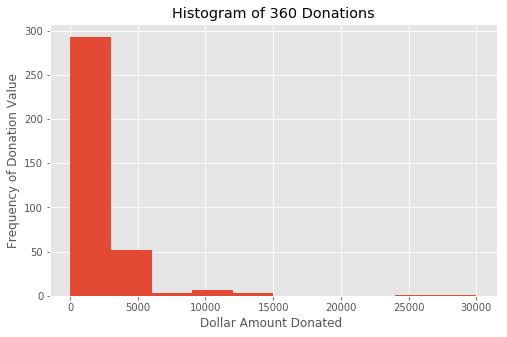

In [19]:
donations['Amount'].plot(kind='hist', figsize=(8,5)) #set graph/visualization type

plt.title('Histogram of 360 Donations') #set title
plt.ylabel('Frequency of Donation Value') #set y value label
plt.xlabel('Dollar Amount Donated ')

In [20]:
#sanjose lat lon
latitude= 37.3394444
longitude= -121.8938889

In [21]:
#defining map upon which we'll build
sjmap= folium.Map(location=[latitude, longitude], zoom_start=12)

In [22]:
sjmap

In [23]:
donations.sort_values(by=['ZIP','Amount'])
#at the bottom, we see some zip codes are missing. 
#we'll need to determine how to include these, as some are large donations

,Name,Entity_City,State,ZIP,Amount,Transaction ID,Date,Recipient,Expense Type,Donor Employer,Organization_Type,Initial Debt,Added Debt,Debt Paid,Remaining Debt,First Name,Transaction Type
77,Henry,Mahwah,NJ,07430,175.0,INC10235,2017-08-22,The Silicon Valley Organization PAC,NaN,Jaguar Land Rover Experience,IND,NaN,NaN,NaN,NaN,Carmen,RCPT
41,"JN Worldwide, LLC",New York,NY,10036,5000.0,INC10163,2017-08-07,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
231,COMCAST Financial Agency Corporation,Philadelphia,PA,19103,5000.0,INC10765,2018-08-15,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
129,COMCAST Financial Agency Corporation,Philadelphia,PA,19103,6500.0,INC10405,2017-12-07,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
239,Lockheed Martin,Bethesda,MD,20817,350.0,INC10773,2018-08-15,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
9,"CBIZ, Inc.",Cleveland,OH,44131,1750.0,INC10097,2017-07-20,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
233,"CBIZ, Inc.",Cleveland,OH,44131,1750.0,INC10767,2018-08-15,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
249,Hensel Phelps Construction Co.,Greeley,CO,80631,1750.0,INC10788,2018-08-20,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
19,Western Alliance Bank,Pheonix,AZ,85004,1000.0,INC10109,2017-07-24,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT
269,Western Alliance Bank,Pheonix,AZ,85004,5000.0,INC10847,2018-09-04,The Silicon Valley Organization PAC,NaN,NaN,OTH,NaN,NaN,NaN,NaN,NaN,RCPT


In [24]:
amountdf= donations[['ZIP','Amount']]
amountdf.head()

,ZIP,Amount
351,90020,30000.0
271,94086,25000.0
337,95814,15000.0
172,94086,15000.0
176,90020,12500.0


In [25]:
print(amountdf.groupby(by=['ZIP','Amount']).sum().groupby(level=[0]).cumsum())

DataError: No numeric types to aggregate

In [ ]:
Zip= donations['ZIP'].value_counts().index.tolist()
Count= donations['ZIP'].value_counts().values.tolist()
#Total= need to figure out how to get sum total of all zip codes remembver to add", Total" to next dictionary when obtained
df_zipcount= {'Zip':Zip, 'Count':Count}
zipcount= pd.DataFrame(df_zipcount)
zipcount.head()

In [ ]:
#get CA zip codes

ca_geo= requests.get("https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/ca_california_zip_codes_geo.min.json")
    
print('GeoJSON file downloaded!')


In [ ]:

sjmap.chloropleth(
    geo_data=ca_geo,
    data=,
    columns='Amount')